In [31]:
library(tidyverse)
library(repr)
library(tidymodels)
options(repr.matrix.max.rows = 6)

In [55]:
heart_data <- read_csv("heart_cleveland_upload.csv")

Parsed with column specification:
cols(
  age = col_double(),
  sex = col_double(),
  cp = col_double(),
  trestbps = col_double(),
  chol = col_double(),
  fbs = col_double(),
  restecg = col_double(),
  thalach = col_double(),
  exang = col_double(),
  oldpeak = col_double(),
  slope = col_double(),
  ca = col_double(),
  thal = col_double(),
  condition = col_double()
)



In [56]:
heart_data

age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,condition
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
69,1,0,160,234,1,2,131,0,0.1,1,1,0,0
69,0,0,140,239,0,0,151,0,1.8,0,2,0,0
66,0,0,150,226,0,0,114,0,2.6,2,0,0,0
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
35,1,3,120,198,0,0,130,1,1.6,1,0,2,1
35,0,3,138,183,0,0,182,0,1.4,0,0,0,0
35,1,3,126,282,0,2,156,1,0.0,0,0,2,1


In [62]:
heart_data <- heart_data %>%
    mutate(sex = as.factor(sex),
           sex = recode(sex, "0" = "female", "1" = "male"),
          cp = as.factor(cp),
           cp = recode(cp, "0" = "typical angina",
                      "1" = "atypical angina",
                      "2" = "non-anginal pain",
                      "3" = "asymptomatic"),
           fbs = as.logical(fbs),
          trestbps = as.numeric(trestbps),
           chol = as.numeric(chol),
          fbs = as.numeric(fbs),
           condition = as.factor(condition),
          condition = recode(condition, "0" = "no disease",
                            "1" = "disease")) %>%
    select(age, sex, cp, trestbps, chol, fbs, condition)
heart_data


          

age,sex,cp,trestbps,chol,fbs,condition
<dbl>,<fct>,<fct>,<dbl>,<dbl>,<dbl>,<fct>
69,male,typical angina,160,234,1,no disease
69,female,typical angina,140,239,0,no disease
66,female,typical angina,150,226,0,no disease
⋮,⋮,⋮,⋮,⋮,⋮,⋮
35,male,asymptomatic,120,198,0,disease
35,female,asymptomatic,138,183,0,no disease
35,male,asymptomatic,126,282,0,disease


age,sex,cp,trestbps,chol,fbs,condition,age_group
<dbl>,<fct>,<fct>,<dbl>,<dbl>,<dbl>,<fct>,<chr>
69,male,typical angina,160,234,1,no disease,old
69,female,typical angina,140,239,0,no disease,old
66,female,typical angina,150,226,0,no disease,old
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
35,male,asymptomatic,120,198,0,disease,young
35,female,asymptomatic,138,183,0,no disease,young
35,male,asymptomatic,126,282,0,disease,young


[1] 91

[1] 121

[1] 85

`summarise()` regrouping output by 'cp' (override with `.groups` argument)



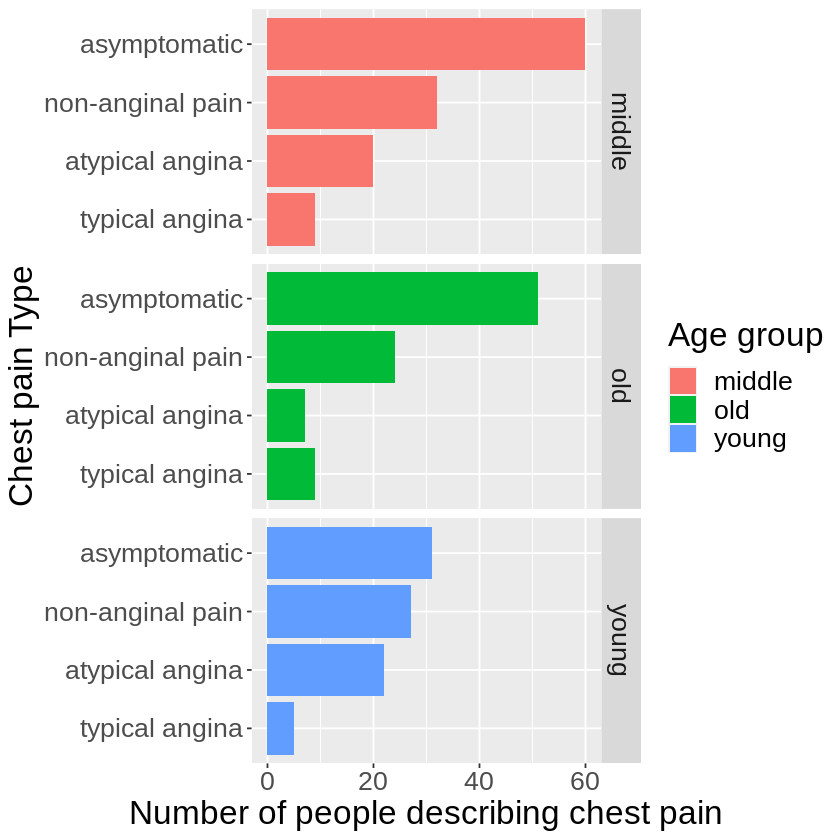

In [63]:
# 1.Divide the dataset into different age group.
heart_data <- within(heart_data,{
  age_group <- NA
  age_group[age>=60]="old"
  age_group[age>= 50 & age < 60] = "middle"
  age_group[age < 50] = "young"
}) 
heart_data

# 2.Count the number in each group
num_old <- heart_data %>%
    filter(age_group == "old") %>%
    nrow()
num_old

num_middle <- heart_data %>%
    filter(age_group == "middle") %>%
    nrow()
num_middle

num_young <- heart_data %>%
    filter(age_group == "young") %>%
    nrow()
num_young

# Note: we can see that the majority of patients with 
# heart failure are between the ages of 50 and 60.

# 3.Find the differnt types of chest pain in each age group
chest_pains_age <- heart_data %>%
    select(cp, age_group) %>%
    group_by(cp, age_group) %>%
    summarize(count = n())

chest_pain_plot <- chest_pains_age %>%
    ggplot(aes(x = count, y = cp, fill = age_group)) +
    geom_bar(stat = "identity", position = "dodge") +
    facet_grid(age_group ~.) +
    labs(x = "Number of people describing chest pain", y = "Chest pain Type",
        fill = "Age group") +
    theme(text = element_text(size = 20))
chest_pain_plot
# 4

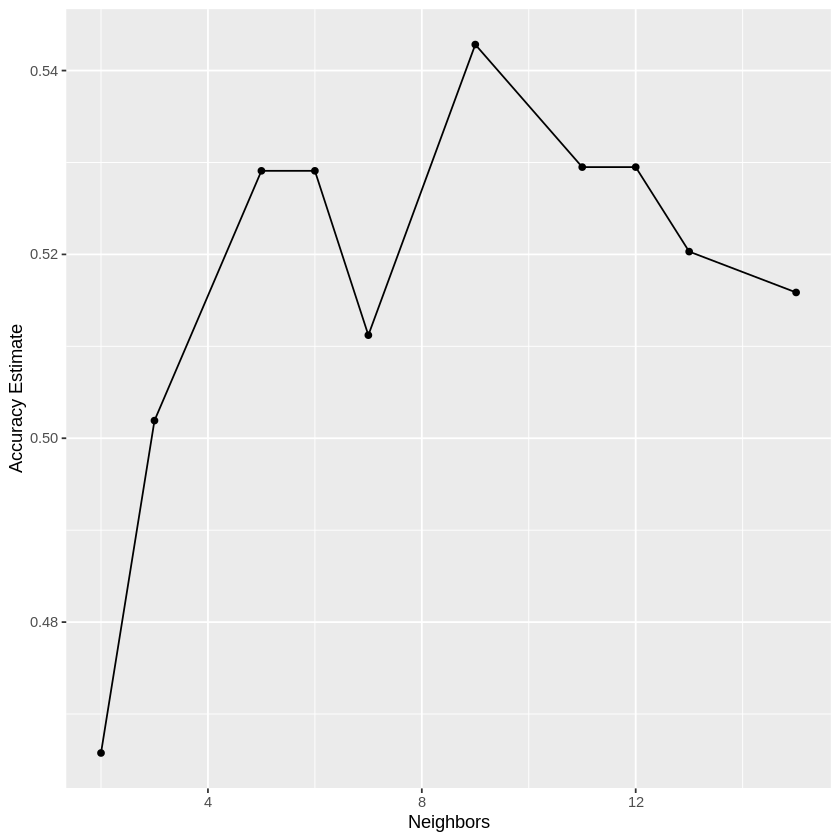

In [67]:
set.seed(2000)
heart_split <- initial_split(heart_data, prop = 0.75, strata = condition)
heart_train <- training(heart_split)
heart_test <- testing(heart_split)

heart_vfold <- vfold_cv(heart_train, v = 5, strata = condition)

heart_recipe <- recipe(condition ~ trestbps + chol + fbs, data = heart_train) %>%
    step_scale(all_predictors()) %>%
    step_center(all_predictors())

knn_tune <- nearest_neighbor(weight_func = "rectangular", 
                             neighbors = tune()) %>%
            set_engine("kknn") %>%
            set_mode("classification")

knn_results <- workflow() %>%
       add_recipe(heart_recipe) %>%
       add_model(knn_tune) %>%
       tune_grid(resamples = heart_vfold, grid = 10) %>%
       collect_metrics()

accuracies <- knn_results %>% 
       filter(.metric == "accuracy")
accuracy_versus_k <- ggplot(accuracies, aes(x = neighbors, y = mean))+
       geom_point() +
       geom_line() +
       labs(x = "Neighbors", y = "Accuracy Estimate")

accuracy_versus_k